In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import datetime
import scipy.linalg as la
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

In [3]:
# Start and end dates  
start_date = datetime.datetime(2020, 1, 1)  
end_date = date.today().strftime('%Y-%m-%d')

# Download the quotes
def get_quotes(tickers, start_date, end_date):
    df_dict = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        df_dict[ticker] = df
        
    full_df = pd.concat(df_dict)
    
    return full_df

# Get the data 
tickers = ['AMZN', 'AAPL', 'MSFT', "HCC", "BCC"]
all_data = get_quotes(tickers, start_date, end_date)
adj_close_prices = all_data['Adj Close'].unstack(level=0)

df_return = adj_close_prices / adj_close_prices.shift(1)
df_r = df_return.dropna()
df_r

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AMZN,AAPL,MSFT,HCC,BCC
Date,,,,,
2020-01-03,0.987861,0.990278,0.987548,1.009709,0.998611
2020-01-06,1.014886,1.007968,1.002585,0.985806,0.996663
2020-01-07,1.002092,0.995297,0.990882,1.018579,0.989676
2020-01-08,0.992191,1.016086,1.015928,1.006384,1.025373
2020-01-09,1.004799,1.021241,1.012493,0.944268,1.041243
...,...,...,...,...,...
2024-12-09,0.995860,1.016101,1.005523,0.995604,0.996298
2024-12-10,0.995356,1.004134,0.993969,1.016717,0.980113
2024-12-11,1.023196,0.994834,1.012767,0.987436,1.000351


In [4]:
# Convert to dictionary for Gurobi
daily_returns = {
    (t, j): df_r.loc[t, j] for t in df_r.index for j in df_r.columns
}

# Mean return for each asset
t, n = df_r.shape
mean = df_r.mean()
sigma = df_r.cov()
sigma_shrink = (t - 1) / (t - n - 2) * sigma
z = la.solve(sigma_shrink, np.ones(n), assume_a="pos")
mu_0 = mean @ z / z.sum()
d = mean - mu_0 * np.ones(n)
y = la.solve(sigma_shrink, d, assume_a="pos")
w = (n + 2) / (n + 2 + t * d @ y)
mu_s = (1 - w) * mean + w * mu_0 * np.ones(n)

mean_return = mu_s.to_dict()

#Time periods and assets
TIME = df_r.index.tolist()
ASSETS = df_r.columns.tolist()

# Gurobi Model Implementation
mu = 0.9 #efficient frontier

model = gp.Model()

# Values for the model parameters
r = 0.1  # Required expected return
l = 0.001  # Minimal position size
K = 5
c = 0.0005  # Fixed transaction costs

# Variables
x = model.addVars(ASSETS, lb=0, ub=1, vtype=gp.GRB.SEMICONT, name="x") # Asset weights
y = model.addVars(TIME, lb=0, name="y")  # Absolute deviations
b = model.addVars(ASSETS, vtype=gp.GRB.BINARY, name="b")

# Objective: Minimize the average absolute deviation
model.setObjective(mu * quicksum(x[j] * mean_return[j] for j in ASSETS) - quicksum(y[t] for j, t in enumerate(TIME)) / len(TIME) , GRB.MAXIMIZE)

# Constraints
# 1. Absolute deviation constraints
for t in TIME:
    portfolio_return_deviation = quicksum(x[j] * (daily_returns[t, j] - mean_return[j]) for j in ASSETS)
    model.addConstr(portfolio_return_deviation <= y[t], name=f"upper_deviation_{t}")
    model.addConstr(portfolio_return_deviation >= -y[t], name=f"lower_deviation_{t}")
    model.addConstr(y[t] >= 0, name=f"positive_risk_{t}")
    
# 2. Sum of weights equals 1
model.addConstr(x.sum() + c * b.sum()  == 1, name="Budget Constraint")

# 3. Minimal return is at leats 11%
model.addConstr(quicksum(x[j] * mean_return[j] for j in ASSETS) >= r, name = "Minimial return")

# 4. Diversification constraints (no short-selling and upper bound with cardinality)
# Cardinality constraint: at most K positions
model.addConstr(b.sum() >= K, name="Diversification")

for j in ASSETS:
    # Force x to 0 if not traded; see formula (1) above
    model.addConstr(x[j] <= b[j], name=f"Indicator_{j}")
   
    # Minimal position; see formula (2) above
    model.addConstr(x[j] >= l * b[j], name=f"Minimal_Position_{j}")

# Optimize the model
model.optimize()
if model.status != gp.GRB.OPTIMAL:
    print(f"Model status: {model.status}")
    
# Display results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    for j in ASSETS:
        print(f"Weight of {j}: {x[j].x:.4f}")
        
    # Assuming `y` is a dictionary-like object with .x as an attribute for risk values
    data = [{"Time": t, "Risk": y[t].x} for t in TIME]
    
    # Convert the data into a DataFrame
    df = pd.DataFrame(data)
    
    # Format the "Risk" column to 4 decimal places
    df["Risk"] = df["Risk"].round(4)
    print(f"Objective Value (Average Absolute Deviation): {model.objVal:.4f}")
else:
    print("No optimal solution found.")

Set parameter Username
Set parameter LicenseID to value 2586077
Academic license - for non-commercial use only - expires 2025-11-17
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 3751 rows, 1256 columns and 16238 nonzeros
Model fingerprint: 0x3a30fd23
Variable types: 1246 continuous, 5 integer (5 binary)
Semi-Variable types: 5 continuous, 0 integer
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [8e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 5e+00]
Presolve removed 1873 rows and 313 columns
Presolve time: 0.02s
Presolved: 1878 rows, 943 columns, 11266 nonzeros
Variable types: 943 continuous, 0 integer (0 binary)

Root relaxation: objective 8.868534e-01, 1202 iterations, 0.07 seconds (0.15 work units)

    Nodes   

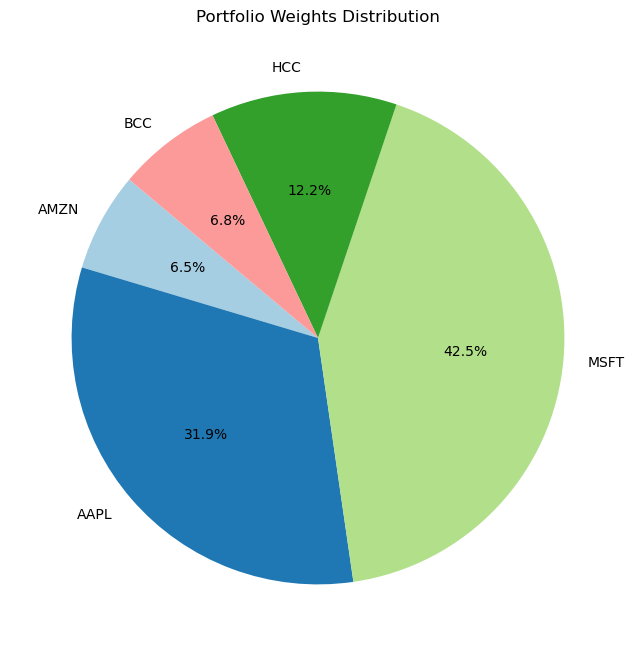

In [47]:
import matplotlib.pyplot as plt

# Data
weights = {
    "AMZN": 0.0647,
    "AAPL": 0.3184,
    "MSFT": 0.4244,
    "HCC": 0.1217,
    "BCC": 0.0683
}

# Extract labels and sizes
labels = list(weights.keys())
sizes = list(weights.values())

# Set color palette
colors = plt.cm.Paired(range(len(weights)))

# Create Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors
)
plt.title("Portfolio Weights Distribution")
plt.show()

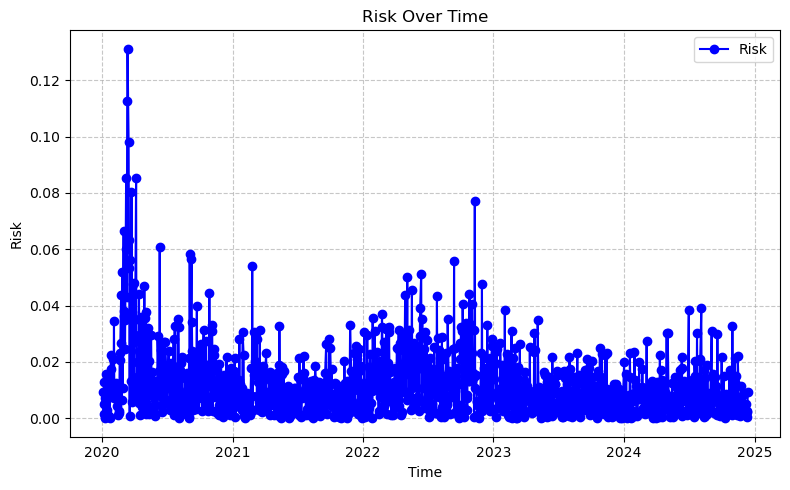

In [51]:
time = df['Time']
risk = df['Risk']

# Create the line graph
plt.figure(figsize=(8, 5))
plt.plot(time, risk, marker='o', linestyle='-', color='b', label='Risk')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title('Risk Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


In [53]:
adj_close_prices

,AMZN,AAPL,MSFT,HCC,BCC
Date,,,,,
2020-01-02,94.900497,72.796036,153.630692,19.285618,26.191235
2020-01-03,93.748497,72.088280,151.717697,19.472855,26.154865
2020-01-06,95.143997,72.662689,152.109909,19.196453,26.067595
2020-01-07,95.343002,72.320984,150.722961,19.553106,25.798483
2020-01-08,94.598503,73.484352,153.123749,19.677925,26.453074
...,...,...,...,...,...
2024-12-09,226.089996,246.750000,446.019989,63.410000,145.320007
2024-12-10,225.039993,247.770004,443.329987,64.470001,142.429993
2024-12-11,230.259995,246.490005,448.989990,63.660000,142.479996
